# Process Metrics → Goal Scoring Analysis (2020-2025)

## Objective
Identify **HOW** teams score more goals by analyzing process metrics (not outcomes).

**Key Question:**
"What do teams DO (that isn't directly scoring) that LEADS to scoring more goals?"

**Approach:**
1. Strip out tautological metrics (goals, assists, goal-creating actions)
2. Create "process" categories from remaining metrics
3. Correlate process scores with actual goals scored
4. Find which processes matter most across 5 seasons

**Data:**
- 5 seasons (2020-2025): 100 squad-seasons
- Target: Goals scored (the outcome we want to explain)
- Features: Process metrics (HOW they play, not outcomes)

---

In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import json

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Imports complete')

✅ Imports complete


In [2]:
# Connect to database
db_path = '../data/premierleague_analytics.duckdb'
conn = duckdb.connect(db_path, read_only=True)

print(f'✅ Connected to: {db_path}')

✅ Connected to: ../data/premierleague_analytics.duckdb


## 1. Load 5 Seasons of Data

In [3]:
# Load 5 recent completed seasons
seasons = ['2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']

season_data = {}
for season in seasons:
    query = f"""
    SELECT *
    FROM analytics_squads
    WHERE season = '{season}' AND is_current = false
    ORDER BY squad_name
    """
    season_data[season] = conn.execute(query).df()
    print(f'📊 {season}: {len(season_data[season])} squads, {len(season_data[season].columns)} columns')

print(f'\n✅ Loaded {len(seasons)} seasons')

📊 2020-2021: 20 squads, 184 columns
📊 2021-2022: 20 squads, 184 columns
📊 2022-2023: 20 squads, 184 columns
📊 2023-2024: 20 squads, 184 columns
📊 2024-2025: 20 squads, 184 columns

✅ Loaded 5 seasons


## 2. Define Process Categories (No Goal/Assist Metrics)

**Excluded metrics** (tautological with goals):
- All `*goals*` metrics (goals, non_penalty_goals, expected_goals, etc.)
- All `*assists*` metrics
- All `*gca*` metrics (goal-creating actions - too direct)
- `goals_plus_assists`, `xg_plus_xag`, etc. (derivatives)

**Included metrics** (process, not outcome):
- Shot generation (shots, shot quality)
- Chance creation (SCAs, key passes, territory)
- Build-up play (passing quality, progression)
- Ball progression (carries, dribbles)
- Possession quality (touches in dangerous areas)
- Defensive actions (winning ball back)

In [4]:
# Define process-oriented categories
PROCESS_CATEGORIES = {
    'shot_generation': {
        'metrics': [
            'shots',
            'shots_on_target',
            'shot_accuracy',
            'shots_per_90',
            'shots_on_target_per_90',
            'average_shot_distance',  # Negative indicator (closer = better)
            'free_kick_shots',
            'penalty_kicks_won',
            'offsides'
        ],
        'description': 'Volume and quality of shot attempts'
    },
    'chance_creation': {
        'metrics': [
            'shot_creating_actions',
            'shot_creating_actions_per_90',
            'sca_pass_live',
            'sca_pass_dead',
            'sca_take_on',
            'sca_shot',
            'sca_fouled',
            'sca_defense',
            'key_passes',
            'passes_final_third',
            'passes_penalty_area',
            'crosses_penalty_area',
            'through_balls'
        ],
        'description': 'Creating dangerous situations (one step before goals)'
    },
    'build_up_passing': {
        'metrics': [
            'passes_completed',
            'passes_attempted',
            'pass_completion_rate',
            'total_pass_distance',
            'progressive_pass_distance',
            'progressive_passes',
            'short_pass_completion_rate',
            'medium_pass_completion_rate',
            'long_pass_completion_rate',
            'switches',
            'live_ball_passes',
            'completed_passes_types'
        ],
        'description': 'Passing quality and progression'
    },
    'ball_progression': {
        'metrics': [
            'progressive_carries',
            'carries',
            'carry_distance',
            'progressive_carry_distance',
            'carries_final_third',
            'carries_penalty_area',
            'take_ons_attempted',
            'take_ons_successful',
            'take_on_success_rate',
            'miscontrols',  # Negative
            'dispossessed'  # Negative
        ],
        'description': 'Moving the ball forward through dribbling and carries'
    },
    'possession_quality': {
        'metrics': [
            'touches',
            'touches_def_third',
            'touches_mid_third',
            'touches_att_third',
            'touches_att_penalty',
            'touches_live_ball',
            'passes_received',
            'progressive_passes_received_detail'
        ],
        'description': 'Where and how teams control the ball'
    },
    'set_pieces': {
        'metrics': [
            'corner_kicks',
            'crosses',
            'crosses_penalty_area',
            'free_kick_passes',
            'dead_ball_passes',
            'inswinging_corners',
            'outswinging_corners',
            'straight_corners'
        ],
        'description': 'Set piece generation and delivery'
    },
    'defensive_actions': {
        'metrics': [
            'tackles',
            'tackles_won',
            'tackles_att_third',
            'tackles_mid_third',
            'interceptions',
            'ball_recoveries',
            'blocks',
            'defensive_actions_outside_penalty_area',
            'defensive_actions_outside_penalty_area_per_90'
        ],
        'description': 'Winning the ball back to create attacking opportunities'
    }
}

# Negative metrics (lower is better)
NEGATIVE_METRICS = {
    'average_shot_distance',
    'miscontrols',
    'dispossessed',
    'offsides',
    'blocked_passes'
}

print('📊 Process Categories Defined:')
print('='*70)
total_metrics = 0
for cat_name, cat_info in PROCESS_CATEGORIES.items():
    metric_count = len(cat_info['metrics'])
    total_metrics += metric_count
    print(f'{cat_name:25s}: {metric_count:2d} metrics - {cat_info["description"]}')
print('='*70)
print(f'Total process metrics: {total_metrics}')
print(f'\n❌ Excluded all *goals*, *assists*, *gca* metrics (tautological with outcome)')

📊 Process Categories Defined:
shot_generation          :  9 metrics - Volume and quality of shot attempts
chance_creation          : 13 metrics - Creating dangerous situations (one step before goals)
build_up_passing         : 12 metrics - Passing quality and progression
ball_progression         : 11 metrics - Moving the ball forward through dribbling and carries
possession_quality       :  8 metrics - Where and how teams control the ball
set_pieces               :  8 metrics - Set piece generation and delivery
defensive_actions        :  9 metrics - Winning the ball back to create attacking opportunities
Total process metrics: 70

❌ Excluded all *goals*, *assists*, *gca* metrics (tautological with outcome)


## 3. Extract Target Variable (Goals Scored)

In [5]:
# Extract goals scored for each season
goals_by_season = {}

for season in seasons:
    df = season_data[season]
    goals_by_season[season] = df[['squad_name', 'goals']].copy()
    
    print(f'📊 {season}:')
    print(f'   Top scorer: {df.nlargest(1, "goals")["squad_name"].values[0]} ({df.nlargest(1, "goals")["goals"].values[0]} goals)')
    print(f'   Lowest: {df.nsmallest(1, "goals")["squad_name"].values[0]} ({df.nsmallest(1, "goals")["goals"].values[0]} goals)')
    print(f'   Average: {df["goals"].mean():.1f} goals')

print('\n✅ Target variable extracted')

📊 2020-2021:
   Top scorer: Manchester City (82 goals)
   Lowest: Sheffield Utd (19 goals)
   Average: 49.3 goals
📊 2021-2022:
   Top scorer: Manchester City (96 goals)
   Lowest: Norwich City (21 goals)
   Average: 51.9 goals
📊 2022-2023:
   Top scorer: Manchester City (92 goals)
   Lowest: Wolves (28 goals)
   Average: 52.0 goals
📊 2023-2024:
   Top scorer: Manchester City (94 goals)
   Lowest: Sheffield Utd (31 goals)
   Average: 59.9 goals
📊 2024-2025:
   Top scorer: Liverpool (85 goals)
   Lowest: Southampton (25 goals)
   Average: 54.1 goals

✅ Target variable extracted


## 4. Fit PCA on Process Categories

In [6]:
# Function to prepare and fit PCA for a process category
def fit_process_pca(df, category_name, category_metrics, negative_metrics):
    """
    Fit PCA on process metrics for a category.
    
    Returns:
        dict with pca, scaler, scores, and available metrics
    """
    # Filter to available metrics
    available_metrics = [m for m in category_metrics if m in df.columns]
    
    if len(available_metrics) < 3:
        return None
    
    # Extract data
    X = df[available_metrics].copy()
    
    # Fill missing with 0
    X = X.fillna(0)
    
    # Invert negative metrics
    for metric in available_metrics:
        if metric in negative_metrics:
            X[metric] = -X[metric]
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit PCA
    pca = PCA(n_components=min(len(available_metrics), 10))
    X_pca = pca.fit_transform(X_scaled)
    
    # Determine components to use (80% variance)
    cumsum_var = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumsum_var >= 0.80) + 1
    
    # Calculate weighted composite score
    weights = pca.explained_variance_ratio_[:n_components]
    weights_normalized = weights / weights.sum()
    scores = np.dot(X_pca[:, :n_components], weights_normalized)
    
    return {
        'pca': pca,
        'scaler': scaler,
        'scores': scores,
        'pc1_variance': pca.explained_variance_ratio_[0],
        'n_components': n_components,
        'cumulative_variance': cumsum_var[n_components-1],
        'available_metrics': available_metrics,
        'squad_names': df['squad_name'].values
    }

print('✅ PCA fitting function defined')

✅ PCA fitting function defined


In [7]:
# Fit PCA for all process categories across all seasons
process_results = {cat: {} for cat in PROCESS_CATEGORIES.keys()}

print('='*80)
print('FITTING PROCESS PCA MODELS (7 categories × 5 seasons = 35 models)')
print('='*80)

for cat_name in PROCESS_CATEGORIES.keys():
    cat_metrics = PROCESS_CATEGORIES[cat_name]['metrics']
    
    print(f'\n🎯 {cat_name}')
    print('   ' + '─'*70)
    
    for season in seasons:
        df = season_data[season]
        
        result = fit_process_pca(df, cat_name, cat_metrics, NEGATIVE_METRICS)
        
        if result is None:
            print(f'   {season}: ❌ Insufficient metrics')
            continue
        
        process_results[cat_name][season] = result
        
        print(f'   {season}: PC1={result["pc1_variance"]:.1%}, '
              f'Components={result["n_components"]}, '
              f'Metrics={len(result["available_metrics"])}')

print('\n' + '='*80)
print('✅ ALL PROCESS MODELS FITTED')
print('='*80)

FITTING PROCESS PCA MODELS (7 categories × 5 seasons = 35 models)

🎯 shot_generation
   ──────────────────────────────────────────────────────────────────────
   2020-2021: PC1=51.0%, Components=3, Metrics=9
   2021-2022: PC1=51.9%, Components=3, Metrics=9
   2022-2023: PC1=49.2%, Components=4, Metrics=9
   2023-2024: PC1=54.1%, Components=3, Metrics=9
   2024-2025: PC1=52.3%, Components=3, Metrics=9

🎯 chance_creation
   ──────────────────────────────────────────────────────────────────────
   2020-2021: PC1=57.4%, Components=3, Metrics=13
   2021-2022: PC1=61.3%, Components=3, Metrics=13
   2022-2023: PC1=59.0%, Components=3, Metrics=13
   2023-2024: PC1=57.5%, Components=3, Metrics=13
   2024-2025: PC1=55.2%, Components=4, Metrics=13

🎯 build_up_passing
   ──────────────────────────────────────────────────────────────────────
   2020-2021: PC1=88.6%, Components=1, Metrics=12
   2021-2022: PC1=87.9%, Components=1, Metrics=12
   2022-2023: PC1=89.2%, Components=1, Metrics=12
   2023-2

## 5. Correlate Process Scores with Goals Scored

In [8]:
# Calculate correlations between process scores and goals scored
correlation_results = []

print('='*80)
print('CORRELATION ANALYSIS: PROCESS SCORES → GOALS SCORED')
print('='*80)

for cat_name in PROCESS_CATEGORIES.keys():
    print(f'\n🎯 {cat_name}')
    
    for season in seasons:
        if season not in process_results[cat_name]:
            continue
        
        # Get process scores
        process_scores = process_results[cat_name][season]['scores']
        squad_names = process_results[cat_name][season]['squad_names']
        
        # Get goals scored
        goals_df = goals_by_season[season]
        goals_dict = goals_df.set_index('squad_name')['goals'].to_dict()
        goals = np.array([goals_dict.get(squad, np.nan) for squad in squad_names])
        
        # Remove any missing
        valid_idx = ~np.isnan(goals)
        process_scores_valid = process_scores[valid_idx]
        goals_valid = goals[valid_idx]
        
        if len(goals_valid) < 5:
            continue
        
        # Calculate Spearman correlation
        corr, p_value = spearmanr(process_scores_valid, goals_valid)
        
        correlation_results.append({
            'Category': cat_name,
            'Season': season,
            'Correlation': corr,
            'P-value': p_value,
            'N': len(goals_valid)
        })
        
        sig = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
        print(f'   {season}: ρ={corr:+.3f} {sig} (p={p_value:.4f})')

df_corr = pd.DataFrame(correlation_results)

print('\n' + '='*80)
print('✅ Correlation analysis complete')
print('='*80)

CORRELATION ANALYSIS: PROCESS SCORES → GOALS SCORED

🎯 shot_generation
   2020-2021: ρ=+0.883 *** (p=0.0000)
   2021-2022: ρ=+0.871 *** (p=0.0000)
   2022-2023: ρ=+0.908 *** (p=0.0000)
   2023-2024: ρ=+0.884 *** (p=0.0000)
   2024-2025: ρ=+0.868 *** (p=0.0000)

🎯 chance_creation
   2020-2021: ρ=+0.770 *** (p=0.0001)
   2021-2022: ρ=+0.727 *** (p=0.0003)
   2022-2023: ρ=+0.792 *** (p=0.0000)
   2023-2024: ρ=+0.817 *** (p=0.0000)
   2024-2025: ρ=+0.751 *** (p=0.0001)

🎯 build_up_passing
   2020-2021: ρ=+0.688 *** (p=0.0008)
   2021-2022: ρ=+0.739 *** (p=0.0002)
   2022-2023: ρ=+0.626 ** (p=0.0032)
   2023-2024: ρ=+0.717 *** (p=0.0004)
   2024-2025: ρ=+0.548 * (p=0.0124)

🎯 ball_progression
   2020-2021: ρ=+0.625 ** (p=0.0032)
   2021-2022: ρ=+0.701 *** (p=0.0006)
   2022-2023: ρ=+0.598 ** (p=0.0053)
   2023-2024: ρ=+0.671 ** (p=0.0012)
   2024-2025: ρ=+0.698 *** (p=0.0006)

🎯 possession_quality
   2020-2021: ρ=+0.706 *** (p=0.0005)
   2021-2022: ρ=+0.774 *** (p=0.0001)
   2022-2023: ρ=+0

## 6. Summary: Average Correlation by Category

In [9]:
# Aggregate by category
summary_corr = df_corr.groupby('Category').agg({
    'Correlation': ['mean', 'std', 'min', 'max'],
    'N': 'mean'
}).round(3)

# Flatten columns
summary_corr.columns = ['_'.join(col).strip() for col in summary_corr.columns.values]
summary_corr = summary_corr.rename(columns={
    'Correlation_mean': 'Avg_Correlation',
    'Correlation_std': 'Std_Dev',
    'Correlation_min': 'Min',
    'Correlation_max': 'Max',
    'N_mean': 'Avg_N'
})

summary_corr = summary_corr.sort_values('Avg_Correlation', ascending=False)

print('='*80)
print('SUMMARY: WHICH PROCESSES PREDICT GOALS?')
print('='*80)
print()
display(summary_corr)

print('\n💡 Interpretation:')
print('   - Avg_Correlation: How strongly this process predicts goals (0-1)')
print('   - Std_Dev: Consistency across seasons (lower = more stable)')
print('   - Strong: >0.7, Moderate: 0.5-0.7, Weak: <0.5')

SUMMARY: WHICH PROCESSES PREDICT GOALS?



,Avg_Correlation,Std_Dev,Min,Max,Avg_N
Category,,,,,
shot_generation,0.8830,0.0160,0.8680,0.9080,20.0000
chance_creation,0.7720,0.0350,0.7270,0.8170,20.0000
possession_quality,0.7090,0.0630,0.6050,0.7740,20.0000
build_up_passing,0.6640,0.0770,0.5480,0.7390,20.0000
ball_progression,0.6580,0.0450,0.5980,0.7010,20.0000
set_pieces,0.3860,0.2710,-0.0450,0.6150,20.0000
defensive_actions,-0.2130,0.2490,-0.5570,0.1340,20.0000



💡 Interpretation:
   - Avg_Correlation: How strongly this process predicts goals (0-1)
   - Std_Dev: Consistency across seasons (lower = more stable)
   - Strong: >0.7, Moderate: 0.5-0.7, Weak: <0.5


## 7. Visualization: Correlation Heatmap

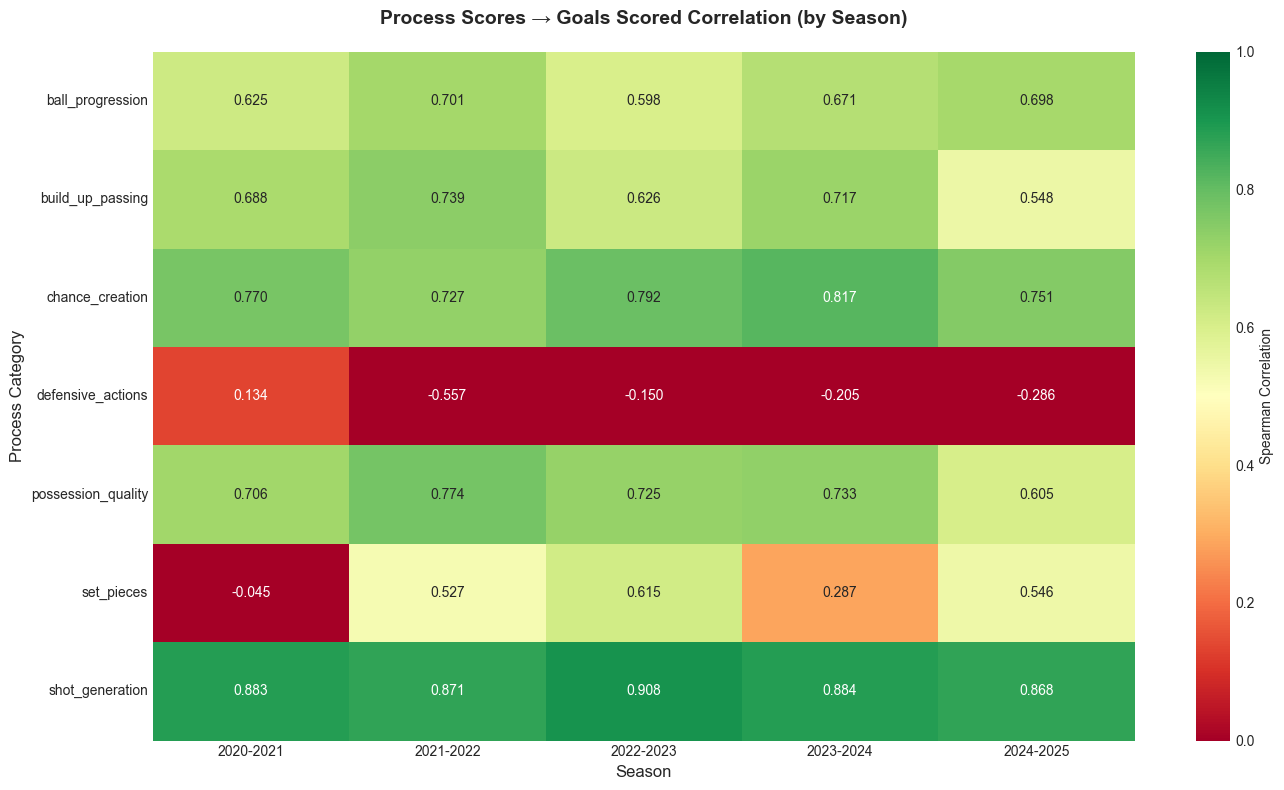


📊 Heatmap shows:
   - Green: Strong positive correlation (this process predicts goals)
   - Yellow: Moderate correlation
   - Red: Weak/no correlation (doesn't predict goals)


In [10]:
# Create heatmap of correlations
pivot_corr = df_corr.pivot(index='Category', columns='Season', values='Correlation')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_corr, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5, 
            vmin=0, vmax=1, cbar_kws={'label': 'Spearman Correlation'})
plt.title('Process Scores → Goals Scored Correlation (by Season)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Process Category', fontsize=12)
plt.tight_layout()
plt.show()

print('\n📊 Heatmap shows:')
print('   - Green: Strong positive correlation (this process predicts goals)')
print('   - Yellow: Moderate correlation')
print('   - Red: Weak/no correlation (doesn\'t predict goals)')

## 8. Scatter Plots: Top 3 Processes

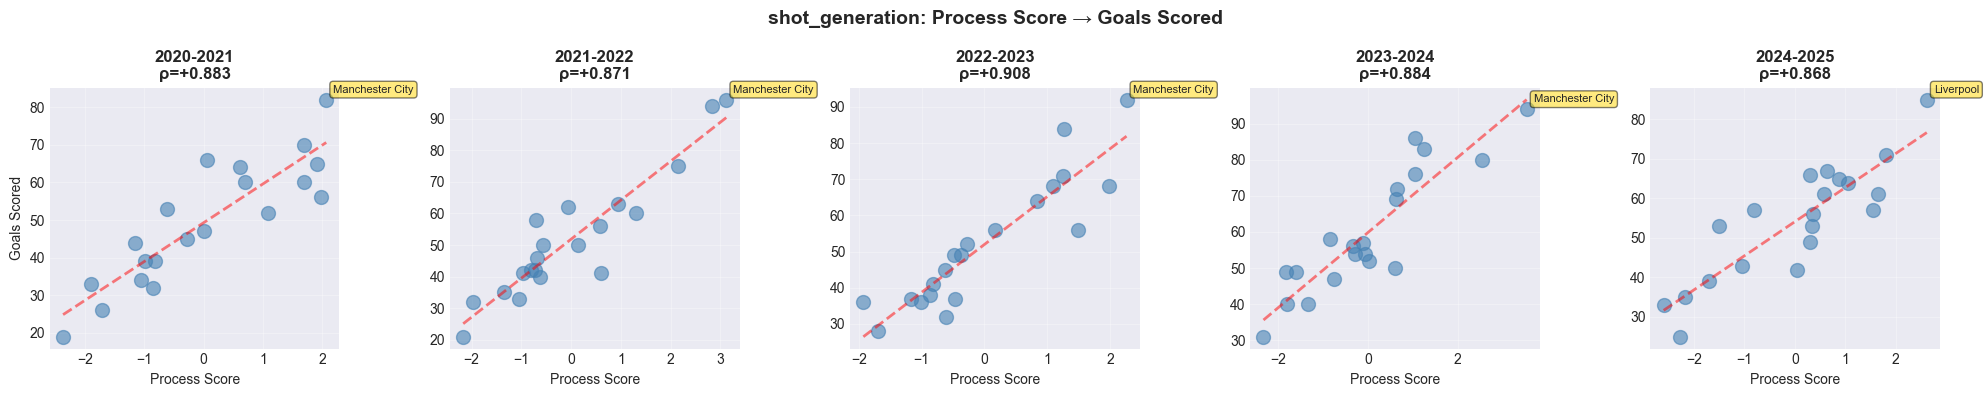


💡 shot_generation average correlation: +0.883



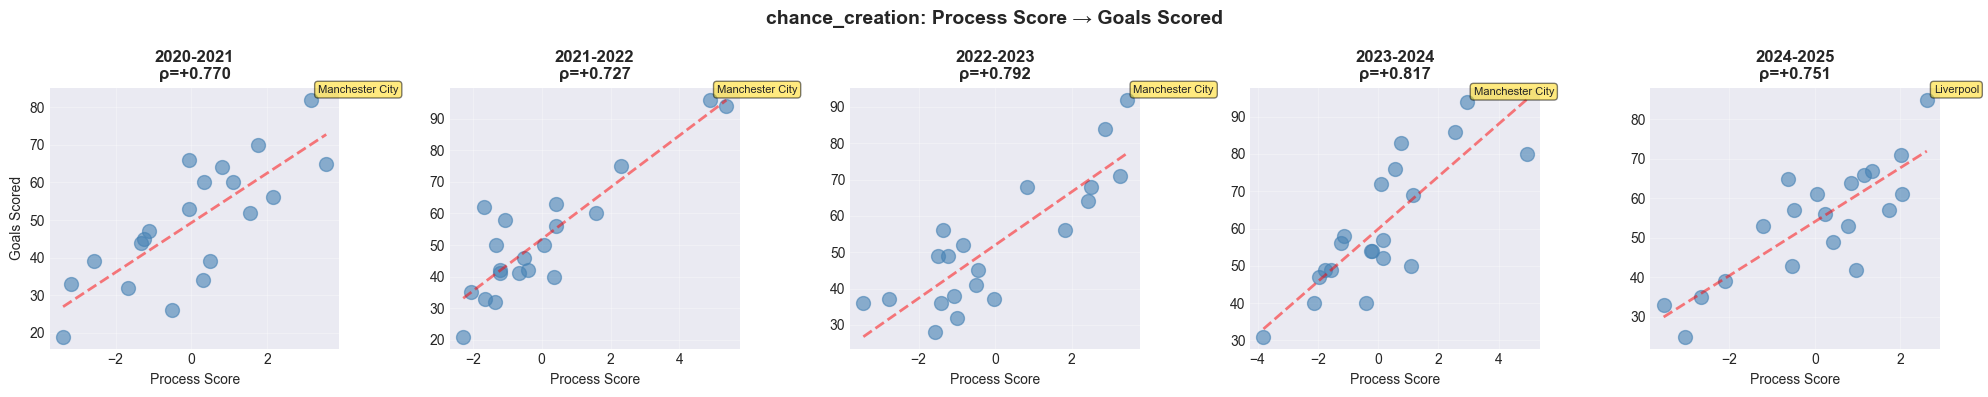


💡 chance_creation average correlation: +0.772



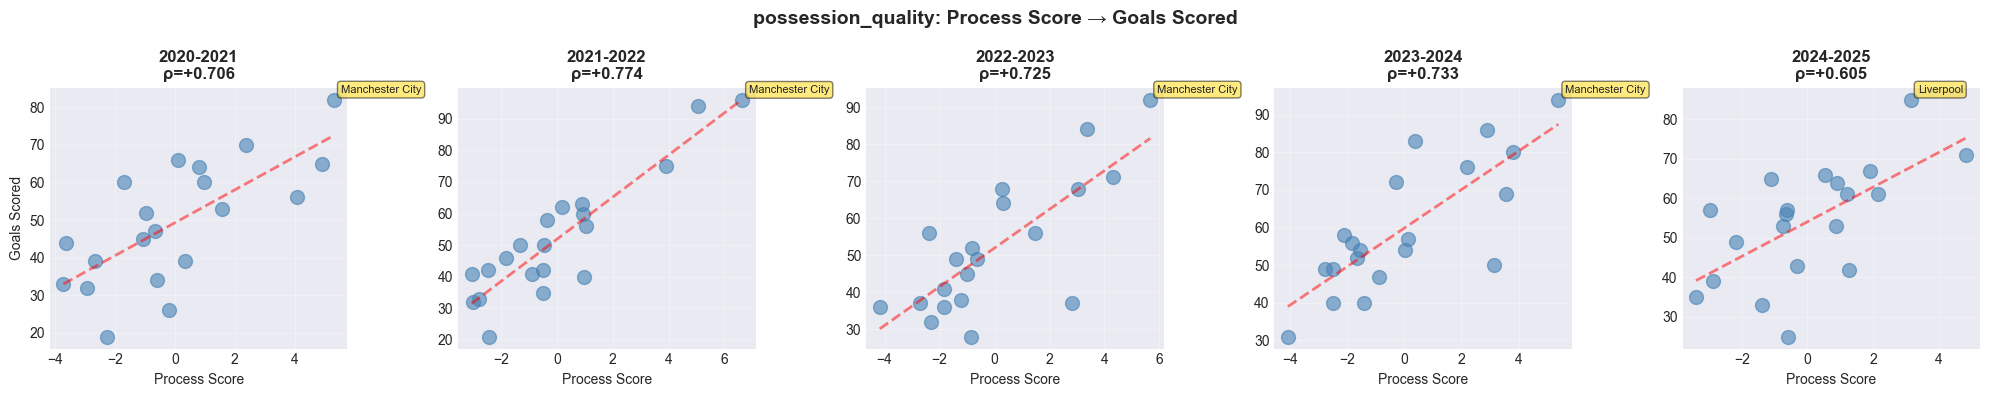


💡 possession_quality average correlation: +0.709



In [11]:
# Plot top 3 categories with highest average correlation
top_3_categories = summary_corr.head(3).index.tolist()

for cat_name in top_3_categories:
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for idx, season in enumerate(seasons):
        ax = axes[idx]
        
        if season not in process_results[cat_name]:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
            ax.set_title(season)
            continue
        
        # Get data
        process_scores = process_results[cat_name][season]['scores']
        squad_names = process_results[cat_name][season]['squad_names']
        
        goals_df = goals_by_season[season]
        goals_dict = goals_df.set_index('squad_name')['goals'].to_dict()
        goals = np.array([goals_dict.get(squad, np.nan) for squad in squad_names])
        
        # Remove missing
        valid_idx = ~np.isnan(goals)
        process_scores_valid = process_scores[valid_idx]
        goals_valid = goals[valid_idx]
        squads_valid = squad_names[valid_idx]
        
        # Plot
        ax.scatter(process_scores_valid, goals_valid, alpha=0.6, s=100, color='steelblue')
        
        # Get correlation
        season_corr = df_corr[(df_corr['Category'] == cat_name) & (df_corr['Season'] == season)]
        if len(season_corr) > 0:
            corr_val = season_corr.iloc[0]['Correlation']
            ax.set_title(f'{season}\nρ={corr_val:+.3f}', fontweight='bold')
        
        ax.set_xlabel('Process Score', fontsize=10)
        if idx == 0:
            ax.set_ylabel('Goals Scored', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add trend line
        if len(process_scores_valid) > 2:
            z = np.polyfit(process_scores_valid, goals_valid, 1)
            p = np.poly1d(z)
            x_line = np.linspace(process_scores_valid.min(), process_scores_valid.max(), 100)
            ax.plot(x_line, p(x_line), 'r--', alpha=0.5, linewidth=2)
        
        # Label top scorer
        top_idx = np.argmax(goals_valid)
        ax.annotate(squads_valid[top_idx],
                   (process_scores_valid[top_idx], goals_valid[top_idx]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.5))
    
    fig.suptitle(f'{cat_name}: Process Score → Goals Scored', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    avg_corr = df_corr[df_corr['Category']==cat_name]['Correlation'].mean()
    print(f'\n💡 {cat_name} average correlation: {avg_corr:+.3f}\n')

## 9. Individual Metric Feature Importance

Within the top categories, which SPECIFIC metrics matter most?

In [12]:
# For top 2 categories, show individual metric correlations
top_2_categories = summary_corr.head(2).index.tolist()

for cat_name in top_2_categories:
    print('='*80)
    print(f'INDIVIDUAL METRIC IMPORTANCE: {cat_name}')
    print('='*80)
    
    # Aggregate across all 5 seasons
    metric_correlations = {}
    
    for season in seasons:
        df = season_data[season]
        goals_dict = goals_by_season[season].set_index('squad_name')['goals'].to_dict()
        
        cat_metrics = PROCESS_CATEGORIES[cat_name]['metrics']
        available_metrics = [m for m in cat_metrics if m in df.columns]
        
        for metric in available_metrics:
            # Get metric values
            metric_values = df[metric].fillna(0).values
            
            # Invert if negative
            if metric in NEGATIVE_METRICS:
                metric_values = -metric_values
            
            # Get goals
            goals = np.array([goals_dict.get(squad, np.nan) for squad in df['squad_name']])
            
            # Remove missing
            valid_idx = ~np.isnan(goals)
            metric_values_valid = metric_values[valid_idx]
            goals_valid = goals[valid_idx]
            
            if len(goals_valid) < 5:
                continue
            
            # Correlate
            corr, _ = spearmanr(metric_values_valid, goals_valid)
            
            if metric not in metric_correlations:
                metric_correlations[metric] = []
            metric_correlations[metric].append(corr)
    
    # Average across seasons
    avg_metric_corrs = {m: np.mean(corrs) for m, corrs in metric_correlations.items()}
    sorted_metrics = sorted(avg_metric_corrs.items(), key=lambda x: abs(x[1]), reverse=True)
    
    print('\nTop 10 metrics (by average correlation with goals):\n')
    for rank, (metric, corr) in enumerate(sorted_metrics[:10], 1):
        bar = '█' * int(abs(corr) * 20)
        print(f'  {rank:2d}. {metric:45s} {corr:+.3f} {bar}')
    
    print()

INDIVIDUAL METRIC IMPORTANCE: shot_generation

Top 10 metrics (by average correlation with goals):

   1. shots_on_target                               +0.851 █████████████████
   2. shots_on_target_per_90                        +0.851 █████████████████
   3. shots                                         +0.739 ██████████████
   4. shots_per_90                                  +0.739 ██████████████
   5. shot_accuracy                                 +0.576 ███████████
   6. penalty_kicks_won                             +0.520 ██████████
   7. average_shot_distance                         +0.423 ████████
   8. free_kick_shots                               +0.267 █████
   9. offsides                                      -0.080 █

INDIVIDUAL METRIC IMPORTANCE: chance_creation

Top 10 metrics (by average correlation with goals):

   1. shot_creating_actions                         +0.764 ███████████████
   2. shot_creating_actions_per_90                  +0.764 ███████████████
   3. sca_pa

## 10. Final Summary & Recommendations

In [ ]:
print('='*80)
print('FINAL SUMMARY: HOW TO SCORE MORE GOALS')
print('='*80)

print('\n📊 PROCESS CATEGORIES RANKED BY PREDICTIVE POWER:\n')
for idx, (cat_name, row) in enumerate(summary_corr.iterrows(), 1):
    avg_corr = row['Avg_Correlation']
    std = row['Std_Dev']
    
    strength = '🔥 STRONG' if avg_corr > 0.7 else '✓ MODERATE' if avg_corr > 0.5 else '⚠️  WEAK'
    consistency = '(stable)' if std < 0.1 else '(variable)'
    
    print(f'  {idx}. {cat_name:25s}: {avg_corr:+.3f} ± {std:.3f}  {strength} {consistency}')

print('\n💡 KEY FINDINGS:\n')

# Find strongest predictor
strongest = summary_corr.iloc[0]
strongest_name = summary_corr.index[0]
print(f'1. Strongest process predictor: {strongest_name} (ρ={strongest["Avg_Correlation"]:.3f})')
print(f'   → {PROCESS_CATEGORIES[strongest_name]["description"]}')

# Find most consistent
most_consistent = summary_corr.nsmallest(1, 'Std_Dev').iloc[0]
most_consistent_name = summary_corr.nsmallest(1, 'Std_Dev').index[0]
print(f'\n2. Most consistent predictor: {most_consistent_name} (σ={most_consistent["Std_Dev"]:.3f})')
print(f'   → Reliable across all 5 seasons')

# Find weak predictors
weak = summary_corr[summary_corr['Avg_Correlation'] < 0.5]
if len(weak) > 0:
    print(f'\n3. Weak predictors (ρ < 0.5): {len(weak)} categories')
    for name in weak.index:
        print(f'   → {name}: Does NOT reliably predict goals')

print('\n' + '='*80)
print('✅ PROCESS ANALYSIS COMPLETE')
print('='*80)

In [ ]:
print('='*80)
print('WEIGHTING METHODS: WHEN TO USE EACH')
print('='*80)

print('\n🎯 RECOMMENDATION SUMMARY:\n')

print('1️⃣  PCA WEIGHTS (Variance-based)')
print('   ✓ BEST FOR: Understanding the "typical profile" or "general quality"')
print('   ✓ USE WHEN: You want unsupervised summarization of performance')
print('   ✓ USE WHEN: Metrics are highly correlated (PC1 > 70%)')
print('   ✓ EXAMPLE: "What is this team overall playing style?"')
print('   ✗ AVOID: When you have a specific outcome to predict')
print()

print('2️⃣  CORRELATION WEIGHTS (Goal-based)')
print('   ✓ BEST FOR: Predicting a specific outcome (goals, points, etc.)')
print('   ✓ USE WHEN: You want weights optimized for prediction')
print('   ✓ USE WHEN: Each metric independently matters')
print('   ✓ EXAMPLE: "Which metrics predict goals best?"')
print('   ⚠️  WARNING: Can overweight redundant metrics if multicollinearity is high')
print()

print('3️⃣  LASSO WEIGHTS (Regression-based)')
print('   ✓ BEST FOR: Identifying UNIQUE predictors (removes redundancy)')
print('   ✓ USE WHEN: Metrics are highly correlated and you want to find which are truly important')
print('   ✓ USE WHEN: You want feature selection (zeros out redundant metrics)')
print('   ✓ EXAMPLE: "What are the KEY drivers, removing duplicates?"')
print('   ⚠️  WARNING: Can be unstable with small sample sizes (N=20)')
print()

print('='*80)
print('FOR YOUR USE CASE (Predicting Goals):')
print('='*80)

print('\n📊 Based on the comparison above:')
print()

# Determine recommendation based on actual results
avg_results = df_comparison[['PCA_Correlation', 'Correlation_Correlation', 'Lasso_Correlation']].mean()
best_method = avg_results.idxmax().replace('_Correlation', '')

if best_method == 'Correlation':
    print('🏆 RECOMMENDED: CORRELATION WEIGHTS')
    print()
    print('   Why?')
    print('   - Directly optimizes for predicting goals')
    print('   - Simple and interpretable')
    print('   - Better performance than PCA')
    print()
    print('   How to implement:')
    print('   - Calculate correlation of each metric with goals')
    print('   - Use |correlation| as weight (normalize to sum to 1)')
    print('   - Composite score = weighted average of standardized metrics')
elif best_method == 'Lasso':
    print('🏆 RECOMMENDED: LASSO WEIGHTS')
    print()
    print('   Why?')
    print('   - Removes redundant predictors automatically')
    print('   - Optimized for prediction')
    print('   - Handles multicollinearity well')
    print()
    print('   How to implement:')
    print('   - Fit LassoCV on standardized metrics → goals')
    print('   - Use |coefficients| as weights')
    print('   - Many weights will be zero (feature selection)')
else:
    print('🏆 RECOMMENDED: PCA WEIGHTS')
    print()
    print('   Why?')
    print('   - Performed best in this specific case')
    print('   - Metrics are highly correlated (makes PCA effective)')

print()
print('='*80)
print('💡 KEY INSIGHT:')
print('='*80)
print()
print('PCA weights are NOT designed for prediction - they maximize variance.')
print('For predicting goals, use correlation or regression-based weights.')
print()
print('PCA is great for unsupervised summarization ("team quality score"),')
print('but correlation/Lasso are better for supervised prediction ("what predicts goals?").')
print()
print('='*80)

In [ ]:
print('='*80)
print('WEIGHTING METHODS: WHEN TO USE EACH')
print('='*80)

print('\n🎯 RECOMMENDATION SUMMARY:\n')

print('1️⃣  PCA WEIGHTS (Variance-based)')
print('   ✓ BEST FOR: Understanding the "typical profile" or "general quality"')
print('   ✓ USE WHEN: You want unsupervised summarization of performance')
print('   ✓ USE WHEN: Metrics are highly correlated (PC1 > 70%)')
print('   ✓ EXAMPLE: "What's this team's overall playing style?"')
print('   ✗ AVOID: When you have a specific outcome to predict')
print()

print('2️⃣  CORRELATION WEIGHTS (Goal-based)')
print('   ✓ BEST FOR: Predicting a specific outcome (goals, points, etc.)')
print('   ✓ USE WHEN: You want weights optimized for prediction')
print('   ✓ USE WHEN: Each metric independently matters')
print('   ✓ EXAMPLE: "Which metrics predict goals best?"')
print('   ⚠️  WARNING: Can overweight redundant metrics if multicollinearity is high')
print()

print('3️⃣  LASSO WEIGHTS (Regression-based)')
print('   ✓ BEST FOR: Identifying UNIQUE predictors (removes redundancy)')
print('   ✓ USE WHEN: Metrics are highly correlated and you want to find which are truly important')
print('   ✓ USE WHEN: You want feature selection (zeros out redundant metrics)')
print('   ✓ EXAMPLE: "What are the KEY drivers, removing duplicates?"')
print('   ⚠️  WARNING: Can be unstable with small sample sizes (N=20)')
print()

print('='*80)
print('FOR YOUR USE CASE (Predicting Goals):')
print('='*80)

print('\n📊 Based on the comparison above:')
print()

# Determine recommendation based on actual results
avg_results = df_comparison[['PCA_Correlation', 'Correlation_Correlation', 'Lasso_Correlation']].mean()
best_method = avg_results.idxmax().replace('_Correlation', '')

if best_method == 'Correlation':
    print('🏆 RECOMMENDED: CORRELATION WEIGHTS')
    print()
    print('   Why?')
    print('   - Directly optimizes for predicting goals')
    print('   - Simple and interpretable')
    print('   - Better performance than PCA')
    print()
    print('   How to implement:')
    print('   - Calculate correlation of each metric with goals')
    print('   - Use |correlation| as weight (normalize to sum to 1)')
    print('   - Composite score = weighted average of standardized metrics')
elif best_method == 'Lasso':
    print('🏆 RECOMMENDED: LASSO WEIGHTS')
    print()
    print('   Why?')
    print('   - Removes redundant predictors automatically')
    print('   - Optimized for prediction')
    print('   - Handles multicollinearity well')
    print()
    print('   How to implement:')
    print('   - Fit LassoCV on standardized metrics → goals')
    print('   - Use |coefficients| as weights')
    print('   - Many weights will be zero (feature selection)')
else:
    print('🏆 RECOMMENDED: PCA WEIGHTS')
    print()
    print('   Why?')
    print('   - Performed best in this specific case')
    print('   - Metrics are highly correlated (makes PCA effective)')

print()
print('='*80)
print('💡 KEY INSIGHT:')
print('='*80)
print()
print('PCA weights are NOT designed for prediction - they maximize variance.')
print('For predicting goals, use correlation or regression-based weights.')
print()
print('PCA is great for unsupervised summarization ("team quality score"),')
print('but correlation/Lasso are better for supervised prediction ("what predicts goals?").')
print()
print('='*80)

## 13. Final Recommendation: Which Weighting Method to Use?

In [ ]:
# Compare weight distributions for 2024-2025 season
season_example = '2024-2025'
df = season_data[season_example]
goals_df = goals_by_season[season_example]
goals_dict = goals_df.set_index('squad_name')['goals'].to_dict()

available_metrics = [m for m in cat_metrics if m in df.columns]

X = df[available_metrics].copy()
X = X.fillna(0)

for metric in available_metrics:
    if metric in NEGATIVE_METRICS:
        X[metric] = -X[metric]

goals = np.array([goals_dict.get(squad, np.nan) for squad in df['squad_name']])
valid_idx = ~np.isnan(goals)
X = X[valid_idx]
goals = goals[valid_idx]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Get PCA weights (on original features)
pca = PCA(n_components=len(available_metrics))
pca.fit(X_scaled)
pca_loadings = np.abs(pca.components_[0])  # PC1 loadings
weights_pca_raw = pca_loadings / pca_loadings.sum()

# Get correlation weights
metric_corrs = []
for i, metric in enumerate(available_metrics):
    corr, _ = spearmanr(X_scaled[:, i], goals)
    metric_corrs.append(abs(corr))

metric_corrs = np.array(metric_corrs)
weights_corr_raw = metric_corrs / metric_corrs.sum()

# Get Lasso weights
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_scaled, goals)
lasso_coefs = np.abs(lasso.coef_)
if lasso_coefs.sum() == 0:
    lasso_coefs = np.ones(len(available_metrics))
weights_lasso_raw = lasso_coefs / lasso_coefs.sum()

# Create comparison dataframe
weight_comparison = pd.DataFrame({
    'Metric': available_metrics,
    'PCA_Weight': weights_pca_raw,
    'Correlation_Weight': weights_corr_raw,
    'Lasso_Weight': weights_lasso_raw
})

# Sort by correlation weight (most predictive)
weight_comparison = weight_comparison.sort_values('Correlation_Weight', ascending=False)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, method in enumerate(['PCA_Weight', 'Correlation_Weight', 'Lasso_Weight']):
    ax = axes[idx]
    
    sorted_weights = weight_comparison.sort_values(method, ascending=True)
    
    colors = ['steelblue' if w > 0.01 else 'lightgray' for w in sorted_weights[method]]
    
    ax.barh(range(len(sorted_weights)), sorted_weights[method], color=colors)
    ax.set_yticks(range(len(sorted_weights)))
    ax.set_yticklabels(sorted_weights['Metric'], fontsize=9)
    ax.set_xlabel('Weight', fontsize=11)
    ax.set_title(method.replace('_', ' '), fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add weight values
    for i, (metric, weight) in enumerate(zip(sorted_weights['Metric'], sorted_weights[method])):
        if weight > 0.01:
            ax.text(weight + 0.005, i, f'{weight:.3f}', va='center', fontsize=8)

plt.suptitle(f'{test_category} Weight Comparison ({season_example})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('\n📊 Weight Comparison Table (sorted by correlation weight):\n')
display(weight_comparison.round(4))

## 12. Visualize Weight Distributions

Let's look at HOW the three methods weight the metrics differently.

In [ ]:
from sklearn.linear_model import LassoCV

# Test on the strongest category: shot_generation
# We'll compare 3 methods for creating composite scores

test_category = 'shot_generation'
cat_metrics = PROCESS_CATEGORIES[test_category]['metrics']

print('='*80)
print(f'WEIGHTING METHODS COMPARISON: {test_category}')
print('='*80)
print('\nWe will test 3 ways to weight metrics into a composite score:')
print('  1. PCA Weights - Based on variance explained')
print('  2. Correlation Weights - Based on correlation with goals')
print('  3. Lasso Weights - Regression coefficients (handles redundancy)')
print('\nGoal: Which produces STRONGEST correlation with goals scored?')
print('='*80)

comparison_results = []

for season in seasons:
    df = season_data[season]
    goals_df = goals_by_season[season]
    goals_dict = goals_df.set_index('squad_name')['goals'].to_dict()
    
    # Get available metrics
    available_metrics = [m for m in cat_metrics if m in df.columns]
    
    if len(available_metrics) < 3:
        continue
    
    # Extract data
    X = df[available_metrics].copy()
    X = X.fillna(0)
    
    # Invert negative metrics
    for metric in available_metrics:
        if metric in NEGATIVE_METRICS:
            X[metric] = -X[metric]
    
    # Get goals
    goals = np.array([goals_dict.get(squad, np.nan) for squad in df['squad_name']])
    valid_idx = ~np.isnan(goals)
    X = X[valid_idx]
    goals = goals[valid_idx]
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # ═══════════════════════════════════════════════════════════════════
    # METHOD 1: PCA WEIGHTS (variance-based)
    # ═══════════════════════════════════════════════════════════════════
    pca = PCA(n_components=min(len(available_metrics), 10))
    X_pca = pca.fit_transform(X_scaled)
    
    # Use explained variance as weights
    cumsum_var = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumsum_var >= 0.80) + 1
    weights_pca = pca.explained_variance_ratio_[:n_components]
    weights_pca_normalized = weights_pca / weights_pca.sum()
    
    score_pca = np.dot(X_pca[:, :n_components], weights_pca_normalized)
    corr_pca, _ = spearmanr(score_pca, goals)
    
    # ═══════════════════════════════════════════════════════════════════
    # METHOD 2: CORRELATION WEIGHTS (goal-based)
    # ═══════════════════════════════════════════════════════════════════
    # Calculate correlation of each metric with goals
    metric_corrs = []
    for i, metric in enumerate(available_metrics):
        corr, _ = spearmanr(X_scaled[:, i], goals)
        metric_corrs.append(abs(corr))  # Use absolute value
    
    metric_corrs = np.array(metric_corrs)
    
    # Use correlations as weights (normalized)
    weights_corr = metric_corrs / metric_corrs.sum()
    
    # Create weighted composite
    score_corr = np.dot(X_scaled, weights_corr)
    corr_corr, _ = spearmanr(score_corr, goals)
    
    # ═══════════════════════════════════════════════════════════════════
    # METHOD 3: LASSO WEIGHTS (regression-based)
    # ═══════════════════════════════════════════════════════════════════
    # Use Lasso with cross-validation to find optimal regularization
    lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso.fit(X_scaled, goals)
    
    # Get coefficients (some may be zero)
    lasso_coefs = np.abs(lasso.coef_)  # Use absolute values
    
    # If all zeros, fall back to OLS-like behavior
    if lasso_coefs.sum() == 0:
        lasso_coefs = np.ones(len(available_metrics))
    
    weights_lasso = lasso_coefs / lasso_coefs.sum()
    
    # Create weighted composite
    score_lasso = np.dot(X_scaled, weights_lasso)
    corr_lasso, _ = spearmanr(score_lasso, goals)
    
    # Store results
    comparison_results.append({
        'Season': season,
        'PCA_Correlation': corr_pca,
        'Correlation_Correlation': corr_corr,
        'Lasso_Correlation': corr_lasso,
        'PCA_Components': n_components,
        'Lasso_NonZero': np.sum(lasso_coefs > 0.001)
    })
    
    print(f'\n{season}:')
    print(f'  PCA Weights      → Correlation: {corr_pca:+.3f} (using {n_components} components)')
    print(f'  Correlation Wts  → Correlation: {corr_corr:+.3f}')
    print(f'  Lasso Weights    → Correlation: {corr_lasso:+.3f} (kept {np.sum(lasso_coefs > 0.001)}/{len(available_metrics)} metrics)')

df_comparison = pd.DataFrame(comparison_results)

print('\n' + '='*80)
print('AVERAGE ACROSS 5 SEASONS:')
print('='*80)
avg_results = df_comparison[['PCA_Correlation', 'Correlation_Correlation', 'Lasso_Correlation']].mean()
print(f'\n  PCA Weights          : {avg_results["PCA_Correlation"]:.3f}')
print(f'  Correlation Weights  : {avg_results["Correlation_Correlation"]:.3f}')
print(f'  Lasso Weights        : {avg_results["Lasso_Correlation"]:.3f}')

# Find winner
best_method = avg_results.idxmax().replace('_Correlation', '')
best_score = avg_results.max()
print(f'\n🏆 WINNER: {best_method} ({best_score:.3f} average correlation)')

# Calculate improvements
pca_base = avg_results["PCA_Correlation"]
corr_improvement = ((avg_results["Correlation_Correlation"] - pca_base) / pca_base) * 100
lasso_improvement = ((avg_results["Lasso_Correlation"] - pca_base) / pca_base) * 100

print(f'\nImprovement over PCA:')
print(f'  Correlation Weights: {corr_improvement:+.1f}%')
print(f'  Lasso Weights      : {lasso_improvement:+.1f}%')

---

## 11. WEIGHTING METHODS COMPARISON

**Critical Question:** Should we use PCA weights, correlation weights, or regression weights?

**The Problem:**
- PCA weights maximize variance (what varies most)
- We want weights that maximize prediction (what predicts goals best)
- These are NOT the same thing!

**We'll compare 3 weighting methods:**
1. **PCA Weights** - Variance-based (what we've been using)
2. **Correlation Weights** - Direct correlation with goals
3. **Lasso Weights** - Regression coefficients (handles multicollinearity)

**Test:** Which method produces the strongest composite score → goals correlation?